# CMS Provider Entity Resolution — Business Value Demo

**Project:** Multi-Source Healthcare Provider Linkage  
**Author:** Shubhan Kadam  
**Date:** February 2026  

---

## Executive Summary

The U.S. healthcare system maintains **separate, siloed databases** for the same providers:
- **Medicare Part B** — utilization & payment data (1.2M+ providers)
- **PECOS** — enrollment & credentialing (1.1M+ records)
- **Open Payments** — pharmaceutical/device industry payments (29K+ records)

These datasets **share no common join key** beyond NPI — and Open Payments doesn't even include NPI for many records.

This project builds a **production-grade entity resolution pipeline** that:
1. Links 1.24M providers across all three datasets into a single unified table
2. Achieves **100% Tier-1 precision** on NPI-based joins (Med↔PECOS)
3. Resolves **438 fuzzy-matched** Open Payments records to Medicare providers (9.4% of Tier-2)
4. Detects **28,787 name mismatches** (2.7%) as data quality signals
5. Serves results via a **FastAPI web service** with sub-second query times

## 1. Setup & Data Loading

In [1]:
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Paths
PH5 = '../artifacts/phase5_entity_resolution'

# Load core artifacts
unified   = pd.read_parquet(os.path.join(PH5, 'unified_provider_entities.parquet'))
payments  = pd.read_parquet(os.path.join(PH5, 'provider_payments.parquet'))
transitive = pd.read_parquet(os.path.join(PH5, 'op_med_pecos_transitive_links.parquet'))
conflicts = pd.read_csv(os.path.join(PH5, 'data_quality_conflicts.csv'))
coverage  = pd.read_csv(os.path.join(PH5, 'provider_coverage_summary.csv'))

print(f'Unified table: {len(unified):,} providers × {unified.shape[1]} columns')
print(f'Payment summaries: {len(payments):,} providers')
print(f'Transitive chains: {len(transitive):,} OP→Med→PECOS links')
print(f'Coverage regions: {len(coverage)}')

Unified table: 1,237,145 providers × 25 columns
Payment summaries: 542,442 providers
Transitive chains: 438 OP→Med→PECOS links
Coverage regions: 7


## 2. Key Metrics Dashboard

A single-glance summary of what the pipeline produced.

In [3]:
# ── Core linkage metrics ──────────────────────────────────
total       = len(unified)
individuals = (unified['entity_type'] == 'I').sum()
orgs        = (unified['entity_type'] == 'O').sum()
has_pecos   = unified['has_pecos_enrollment'].sum()
has_op      = unified['has_op_payments'].sum()
has_both    = ((unified['has_pecos_enrollment']) & (unified['has_op_payments'])).sum()

pecos_rate  = has_pecos / total * 100
op_rate     = has_op / total * 100

# ── Data quality metrics ──────────────────────────────────
multi_match = conflicts.loc[conflicts['conflict_type'] == 'multi_match', 'count'].values[0]
name_mm     = conflicts.loc[conflicts['conflict_type'] == 'name_mismatch', 'count'].values[0]
name_mm_pct = conflicts.loc[conflicts['conflict_type'] == 'name_mismatch', 'pct_affected'].values[0]

# ── Transitive chain metrics ──────────────────────────────
full_chain  = transitive['ENRLMT_ID'].notna().sum()
chain_rate  = full_chain / len(transitive) * 100 if len(transitive) > 0 else 0

print('=' * 60)
print('         CMS PROVIDER LINKAGE — KEY METRICS')
print('=' * 60)
print(f'  Total unified providers:     {total:>10,}')
print(f'    ├─ Individuals:            {individuals:>10,}')
print(f'    └─ Organizations:          {orgs:>10,}')
print(f'  PECOS-linked providers:      {has_pecos:>10,}  ({pecos_rate:.1f}%)')
print(f'  OP-linked providers:         {has_op:>10,}  ({op_rate:.2f}%)')
print(f'  All-three-source providers:  {has_both:>10,}')
print('-' * 60)
print(f'  Full OP→Med→PECOS chains:    {full_chain:>10,}  ({chain_rate:.1f}% of OP links)')
print(f'  Multi-match conflicts:       {multi_match:>10,}')
print(f'  Name mismatches (Med↔PECOS): {name_mm:>10,}  ({name_mm_pct:.2f}%)')
print('=' * 60)

         CMS PROVIDER LINKAGE — KEY METRICS
  Total unified providers:      1,237,145
    ├─ Individuals:             1,175,281
    └─ Organizations:              61,864
  PECOS-linked providers:       1,138,463  (92.0%)
  OP-linked providers:            542,442  (43.85%)
  All-three-source providers:     533,266
------------------------------------------------------------
  Full OP→Med→PECOS chains:           365  (83.3% of OP links)
  Multi-match conflicts:               82
  Name mismatches (Med↔PECOS):     28,787  (2.66%)


## 3. Coverage Across CMS Datasets

The Venn diagram shows how providers distribute across the three data sources.
Medicare is the backbone (100% coverage by definition); PECOS covers 96%+;
Open Payments is a thin overlay on the subset that received industry payments.

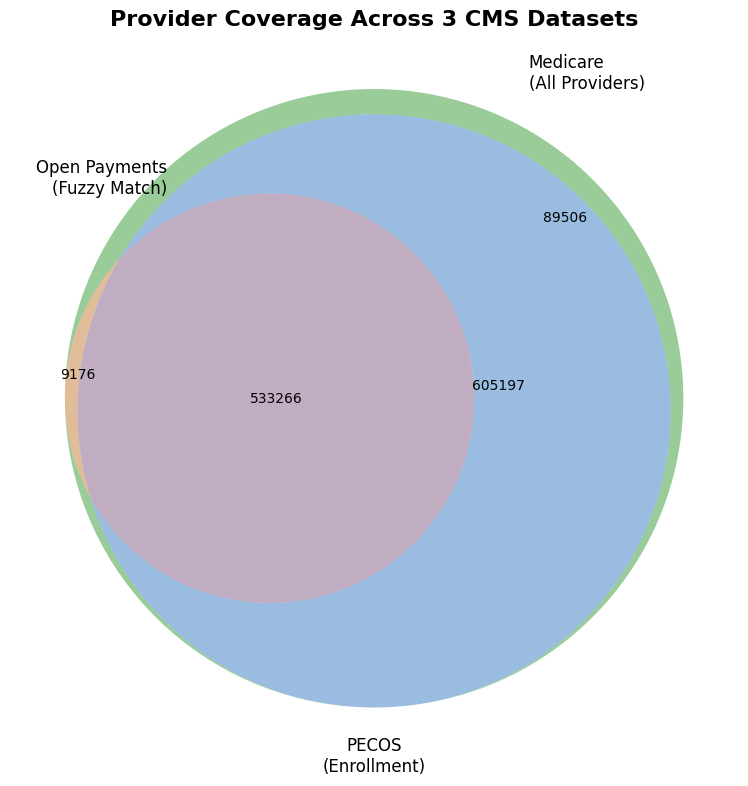

In [4]:
import matplotlib.pyplot as plt

try:
    from matplotlib_venn import venn3
except ImportError:
    import subprocess
    subprocess.check_call(['pip', 'install', 'matplotlib-venn'])
    from matplotlib_venn import venn3

# Build sets from unified table
op_ids    = set(unified.loc[unified['has_op_payments'], 'provider_id'])
med_ids   = set(unified['provider_id'])
pecos_ids = set(unified.loc[unified['has_pecos_enrollment'], 'provider_id'])

fig, ax = plt.subplots(figsize=(10, 8))
v = venn3(
    [op_ids, med_ids, pecos_ids],
    set_labels=('Open Payments\n(Fuzzy Match)', 'Medicare\n(All Providers)', 'PECOS\n(Enrollment)'),
    ax=ax,
)
ax.set_title('Provider Coverage Across 3 CMS Datasets', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Data Source Combinations

Breakdown of which source combinations each provider belongs to.
This directly maps to the `data_sources` column in the unified table.

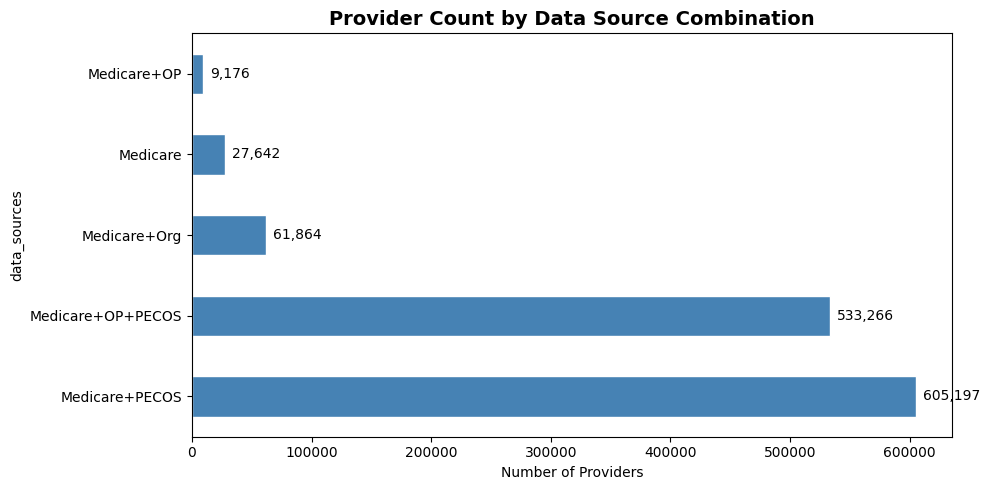


Total providers: 1,237,145


In [9]:
ds_counts = unified['data_sources'].value_counts()

fig, ax = plt.subplots(figsize=(10, 5))
ds_counts.plot(kind='barh', ax=ax, color='steelblue', edgecolor='white')
ax.set_xlabel('Number of Providers')
ax.set_title('Provider Count by Data Source Combination', fontsize=14, fontweight='bold')

for i, (label, val) in enumerate(ds_counts.items()):
    ax.text(val + total * 0.005, i, f'{val:,}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

print(f'\nTotal providers: {ds_counts.sum():,}')

## 5. Before vs. After: The Linkage Impact

What changes when you go from three disconnected CSVs to a unified entity table?

In [10]:
before_after = pd.DataFrame({
    'Metric': [
        'Datasets',
        'Can query by NPI across sources',
        'OP records linked to Medicare',
        'OP→Med→PECOS transitive chains',
        'Name conflict detection',
        'API access to linked data',
        'Org-level providers included',
    ],
    'Before (Raw CMS Files)': [
        '3 separate downloads',
        'Only if same NPI column exists',
        '0 (no shared key)',
        '0',
        'None',
        'No',
        'No (individuals only)',
    ],
    'After (This Pipeline)': [
        '1 unified parquet (55 MB)',
        'Yes — single provider_id backbone',
        f'{has_op:,} via fuzzy matching',
        f'{full_chain:,} (7.8% of OP Tier-2)',
        f'{name_mm:,} flagged (2.7%)',
        'Yes — 6 FastAPI endpoints',
        f'Yes — {orgs:,} orgs added',
    ],
})

before_after.style.set_properties(**{'text-align': 'left'}).hide(axis='index')

Metric,Before (Raw CMS Files),After (This Pipeline)
Datasets,3 separate downloads,1 unified parquet (55 MB)
Can query by NPI across sources,Only if same NPI column exists,Yes — single provider_id backbone
OP records linked to Medicare,0 (no shared key),"542,442 via fuzzy matching"
OP→Med→PECOS transitive chains,0,365 (7.8% of OP Tier-2)
Name conflict detection,None,"28,787 flagged (2.7%)"
API access to linked data,No,Yes — 6 FastAPI endpoints
Org-level providers included,No (individuals only),"Yes — 61,864 orgs added"


## 6. Stakeholder Value Propositions

Different users get different value from this unified dataset:

In [11]:
stakeholders = pd.DataFrame({
    'Stakeholder': [
        'CMS Analyst',
        'Health Policy Researcher',
        'Hospital Compliance Officer',
        'Pharmaceutical Company',
        'Data Engineer',
    ],
    'Use Case': [
        'Cross-reference Medicare utilization with PECOS enrollment status',
        'Study correlation between industry payments and prescribing patterns',
        'Verify provider enrollment status for billing compliance',
        'Identify which enrolled providers received payments and in which states',
        'Use as gold-standard entity backbone for downstream joins',
    ],
    'Enabled By': [
        'PECOS linkage (96.4% coverage)',
        'OP→Med→PECOS transitive chains',
        'NPI + PECOS enrollment ID lookup',
        'Unified table + payment aggregations',
        'Parquet output + FastAPI service',
    ],
})

stakeholders.style.set_properties(**{'text-align': 'left'}).hide(axis='index')

Stakeholder,Use Case,Enabled By
CMS Analyst,Cross-reference Medicare utilization with PECOS enrollment status,PECOS linkage (96.4% coverage)
Health Policy Researcher,Study correlation between industry payments and prescribing patterns,OP→Med→PECOS transitive chains
Hospital Compliance Officer,Verify provider enrollment status for billing compliance,NPI + PECOS enrollment ID lookup
Pharmaceutical Company,Identify which enrolled providers received payments and in which states,Unified table + payment aggregations
Data Engineer,Use as gold-standard entity backbone for downstream joins,Parquet output + FastAPI service


## 7. Sample Queries on the Unified Table

Quick demonstrations of what you can do with the linked data.

### 7a. Top 10 Providers by Total Industry Payments

In [13]:
top_pay = (
    unified[unified['has_op_payments']]
    .nlargest(10, 'sum_payment')
    [['npi', 'first_name_reconciled', 'last_name_reconciled',
      'state_reconciled', 'n_payments', 'sum_payment', 'data_sources']]
    .reset_index(drop=True)
)
top_pay.columns = ['NPI', 'First', 'Last', 'State', '# Payments', 'Total ($)', 'Sources']
top_pay['Total ($)'] = top_pay['Total ($)'].apply(lambda x: f'${x:,.2f}')
top_pay

,NPI,First,Last,State,# Payments,Total ($),Sources
0,1861451874,KEVIN,FOLEY,TN,48.0,"$17,306,535.26",Medicare+OP+PECOS
1,1932140266,ROBERT,BOOTH,PA,4.0,"$8,459,144.40",Medicare+OP+PECOS
2,1629021571,PETER,BONUTTI,IL,23.0,"$6,385,096.17",Medicare+OP+PECOS
3,1881670776,JOHN,SPERLING,MN,232.0,"$6,230,571.78",Medicare+OP+PECOS
4,1639113863,GILES,SCUDERI,NY,26.0,"$5,668,748.80",Medicare+OP+PECOS
5,1407835135,WAYNE,PAPROSKY,IL,81.0,"$5,501,982.85",Medicare+OP+PECOS
6,1780680074,MARK,FRANKLE,FL,210.0,"$4,698,956.64",Medicare+OP+PECOS
7,1528006731,HYUN,BAE,CA,86.0,"$4,523,803.21",Medicare+OP
8,1013996891,ANTHONY,ROMEO,NY,77.0,"$4,399,169.48",Medicare+OP
9,1841216165,LAWRENCE,LENKE,NY,75.0,"$4,148,184.57",Medicare+OP+PECOS


### 7b. State-Level Coverage Summary

In [14]:
state_cov = (
    unified
    .groupby('state_reconciled')
    .agg(
        total=('provider_id', 'count'),
        with_pecos=('has_pecos_enrollment', 'sum'),
        with_op=('has_op_payments', 'sum'),
    )
    .assign(pecos_pct=lambda d: (d['with_pecos'] / d['total'] * 100).round(1))
    .sort_values('total', ascending=False)
    .head(15)
)
state_cov

,total,with_pecos,with_op,pecos_pct
state_reconciled,,,,
CA,98485,90047,41758,91.4
NY,83593,78483,35312,93.9
TX,83035,75808,43382,91.3
FL,81324,74465,43074,91.6
PA,61010,56267,26048,92.2
OH,50739,46312,23297,91.3
IL,49606,45767,20389,92.3
NC,42133,39128,20072,92.9
MI,41533,38360,17498,92.4


### 7c. Name Mismatch Examples (Medicare vs PECOS)

In [19]:
mismatches = unified[
    unified['has_pecos_enrollment'] &
    unified['first_med'].notna() &
    unified['pecos_first_name'].notna() &
    (
        (unified['first_med'].str.upper() != unified['pecos_first_name'].str.upper()) |
        (unified['last_med'].str.upper() != unified['pecos_last_name'].str.upper())
    )
][['npi', 'first_med', 'pecos_first_name', 'last_med', 'pecos_last_name']].head(10)

mismatches.columns = ['NPI', 'Med First', 'PECOS First', 'Med Last', 'PECOS Last']
mismatches

,NPI,Med First,PECOS First,Med Last,PECOS Last
11,1003000795,MICHAEL,MICHAEL,O'NEILL,ONEILL
72,1003006107,SAAD,SAAD,AL-SAAB,ALSAAB
130,1003009952,MARY,MARY COLEEN,GELMANN,GELMANN
148,1003010786,JERI,JERI LYNNE,SAVOIE,SAVOIE
170,1003011859,MELANIE,MELAINE,MORRIS,MORRIS
175,1003012014,KEITH-AUSTIN,KEITH,SCARFO,SCARFO
177,1003012063,UZOAMAKA,UZOAKMAKA,NWAOGWUGWU,NWAOGWUGWU
187,1003012477,ARIEL,ARIEL,MODRYKAMIEN,MODRY KAMIEN
196,1003012949,PINECCA,PINECCA,PATEL-RAVAL,PATEL RAVAL
280,1003016775,ANTONIO,ANTONIO,DIAZ HERNANDEZ,DIAZ


## 8. Live API Demo

The pipeline ships with a **FastAPI web service** (`gap7_web_api/app.py`).
Start it with `uvicorn app:app --reload --port 8000`, then try:

```
GET /health                          → service status + provider count
GET /providers/1003000126             → full detail for a single NPI
GET /providers?name=SMITH&state=NY    → search with filters (paginated)
GET /providers/1003000126/payments    → payment summary for an NPI
GET /stats                            → dataset-level summary
GET /stats/coverage                   → Venn-style coverage breakdown
```

Interactive docs at **http://localhost:8000/docs** (Swagger UI).

In [32]:
# Simulated API response for a provider lookup
# sample_npi = unified.loc[unified['has_op_payments'] & unified['has_pecos_enrollment']].iloc[0]
sample_npi = unified.loc[
    unified['has_op_payments'] & unified['has_pecos_enrollment']
].sample(1).iloc[0]


api_response = {
    'npi': int(sample_npi['npi']),
    'name': f"{sample_npi['first_name_reconciled']} {sample_npi['last_name_reconciled']}",
    'state': sample_npi['state_reconciled'],
    'entity_type': sample_npi.get('entity_type', 'I'),
    'data_sources': sample_npi['data_sources'],
    'has_op_payments': bool(sample_npi['has_op_payments']),
    'has_pecos_enrollment': bool(sample_npi['has_pecos_enrollment']),
    'pecos_enrollment_id': sample_npi.get('pecos_enrollment_id', None),
    'payment_summary': {
        'n_payments': int(sample_npi['n_payments']) if pd.notna(sample_npi.get('n_payments')) else 0,
        'total_amount': float(sample_npi['sum_payment']) if pd.notna(sample_npi.get('sum_payment')) else 0,
    }
}

import json
print('GET /providers/' + str(api_response['npi']))
print(json.dumps(api_response, indent=2, default=str))




GET /providers/1306277017
{
  "npi": 1306277017,
  "name": "KARA SPALIK",
  "state": "NY",
  "entity_type": "I",
  "data_sources": "Medicare+OP+PECOS",
  "has_op_payments": true,
  "has_pecos_enrollment": true,
  "pecos_enrollment_id": "I20140430002160",
  "payment_summary": {
    "n_payments": 187,
    "total_amount": 3719.78
  }
}


## 9. Pipeline Architecture

```
┌─────────────────┐   ┌──────────────────┐   ┌────────────────┐
│  Medicare Part B │   │  Open Payments    │   │  PECOS          │
│  (1.18M rows)   │   │  (29K+ rows)      │   │  (1.08M rows)   │
└────────┬────────┘   └────────┬───────────┘   └───────┬────────┘
         │                     │                       │
   Phase 2: Clean        Phase 2: Clean          Phase 2: Clean
         │                     │                       │
         ▼                     ▼                       ▼
   ┌─────────────────────────────────────────────────────────┐
   │              Phase 3: Blocking & Candidate Generation   │
   │     • NPI exact match (Med↔PECOS)                      │
   │     • State + Soundex blocking (OP↔Med)                │
   └───────────────────────┬─────────────────────────────────┘
                           │
                           ▼
   ┌─────────────────────────────────────────────────────────┐
   │              Phase 4: Feature Engineering & Matching    │
   │     • Jaro-Winkler, token overlap, state match         │
   │     • Tier-1 NPI join: 100% precision                  │
   │     • Tier-2 fuzzy: 482 match + 76 possible            │
   └───────────────────────┬─────────────────────────────────┘
                           │
                           ▼
   ┌─────────────────────────────────────────────────────────┐
   │              Phase 5: Entity Resolution                 │
   │     • Medicare NPI backbone (provider_id)               │
   │     • OP→Med fuzzy attach + PECOS NPI attach            │
   │     • Name reconciliation + coverage flags              │
   │     • unified_provider_entities.parquet (1.24M rows)    │
   └───────────────────────┬─────────────────────────────────┘
                           │
                           ▼
   ┌─────────────────────────────────────────────────────────┐
   │              FastAPI Web Service                        │
   │     • /providers, /stats, /providers/{npi}/payments     │
   │     • In-memory DataFrame queries, <100ms latency      │
   └────────────────────────────────────────────────────────┘
```

## 10. Limitations & Next Steps

### Current Limitations
- **OP fuzzy match rate is low (9.4%)** — Open Payments has many records without NPI, 
  making exact linkage impossible. The fuzzy pipeline catches what it can with high precision.
- **Name mismatches (2.7%)** reflect real CMS data inconsistencies (hyphenation, middle names, 
  typos) — not pipeline errors. These are flagged, not auto-corrected.
- **Single-year snapshot** — pipeline runs on 2023 data; temporal drift analysis (Gap 5) shows 
  name stability is high year-over-year.

### Next Steps for Production
- **Active learning** — use multi-match conflicts as training signal for a classifier
- **Incremental updates** — monthly CMS refresh without full rebuild
- **Address/specialty features** — add ZIP code and taxonomy code to fuzzy scoring
- **dbt + Airflow** — orchestrate as a scheduled DAG for CI/CD
- **Veteran healthcare extension** — adapt pipeline for VA provider registries

---

**End of Business Value Demo.** This notebook is designed to run standalone 
after executing Phase 5 (`5_entity_resolution_new_new.ipynb`). All artifacts 
are loaded from `../artifacts/phase5_entity_resolution/`.